# Проведение А/В-тестирования

Вместе с отделом маркетинга подготовили список гипотез для увеличения выручки.

У нас в наличии три датафрейма: 1) с расчитанными параметрами Reach, Impact, Confidence, Efforts; 2) остальные данные получены в ходе проведённого А/В-теста и описывают сколько, в какие даты и какими пользователями было сделано заказов и общее количество посетителей сервиса. 

Необходимо приоритизировать гипотезы.

- Приоритизируем гипотезы с помощью фреймворка ICE.
- Приоритизируем гипотезы с помощью фреймворка RICE.
- Рассмотрим получившиеся данные.

Затем необходимо проанализировать результаты проведённого A/B-теста.

- Рассмотрим кумулятивную выручку, средний чек и конверсию по группам.
- Рассмотрим относительное изменение кумулятивного среднего чека и конверсии экспериментальной группы относительно стандартной.
- Посчитаем статистическую значимость различий в конверсии и в среднем чеке заказа между группами.
- Если будут аномалии, посчитаем статистическую значимость различий в конверсии и в среднем чеке заказа между группами по уже "очищенным" данным. Рассмотрим как изменятся выводы.
- Примем решение по итогам проведённых действий.

## Приоритизация гипотез

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Расчёт ICE и сортировка по убыванию.

In [3]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis.sort_values(by='ICE', ascending=False).style.set_properties(subset=['Hypothesis'], **{'width': '300px'})

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


Лучший результат у восьмой гипотезы.

Расчёт RICE.

In [4]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis.sort_values(by='RICE', ascending=False).style.set_properties(subset=['Hypothesis'], **{'width': '300px'})

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.000000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.000000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.000000


При расчёте RICE лучше уже седьмая гипотеза. 

### Вывод

При расчёте ICE лучший результат у восьмой гипотезы.

При расчёте RICE лучше уже седьмая гипотеза. 

При расчёте ICE и RICE в топе находятся одни и те же гипотезы, различается их приоритетность. В RICE появляется параметр Reach (Охват - скольких пользователей затронет измененение), чем этот параметр выше, тем будет выше итоговый расчёт приоритетности.

## Анализ A/B-теста

In [5]:
orders = pd.read_csv('/datasets/orders.csv')
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Приведём названия столбцов к "змеиному регистру" и уберём прописные буквы.

In [6]:
orders.columns = [x.lower().replace('id', '_id') for x in orders.columns]

In [7]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [8]:
group_a = orders[orders['group'] == 'A']
group_b = orders[orders['group'] == 'B']

In [9]:
doubled_visitors = list(np.intersect1d(group_a['visitor_id'], group_b['visitor_id']))
len(doubled_visitors)

58

In [10]:
group_double = orders[orders['visitor_id'].isin(doubled_visitors)]

In [11]:
print('Доля задвоенных пользователей от общего числа: {0:.2f}'.format(len(doubled_visitors) / orders['visitor_id'].nunique() * 100))
print('Доля задвоенных пользователей в группе А: {0:.2f}'.format(len(doubled_visitors) / group_a['visitor_id'].nunique() * 100))
print('Доля задвоенных пользователей в группе B: {0:.2f}'.format(len(doubled_visitors) / group_b['visitor_id'].nunique() * 100))

Доля задвоенных пользователей от общего числа: 5.63
Доля задвоенных пользователей в группе А: 11.53
Доля задвоенных пользователей в группе B: 9.90


Думаю, возможно удалить этих пользователей и продолжить анализ.

In [12]:
orders_filtered = orders.drop(index=list(group_double.index)).reset_index(drop=True)
orders_filtered

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,3797467345,1196621759,2019-08-15,9759,B
3,2282983706,2322279887,2019-08-15,2308,B
4,182168103,935554773,2019-08-15,2210,B
...,...,...,...,...,...
1011,3592955527,608641596,2019-08-14,16490,B
1012,2662137336,3733762160,2019-08-14,6490,B
1013,2203539145,370388673,2019-08-14,3190,A
1014,1807773912,573423106,2019-08-14,10550,A


Теперь необходимо убрать посещения этих пользователей из датафрейма "visitors" в дни когда они делали заказы.

In [13]:
double_visitors_per_date = group_double.groupby(['date', 'group'])['revenue'].count()
visitors = visitors.merge(double_visitors_per_date, on=['date', 'group'], how='outer')
visitors['revenue'] = visitors['revenue'].fillna(0).astype('float')
visitors['visitors'] = visitors['visitors'] - visitors['revenue']
visitors = visitors[['date', 'group', 'visitors']]

### Вывод 

Изменили стиль заголовков столбцов. Пропусков нет, можно приступать к дальнейшим шагам.

### Кумулятивная выручка по группам

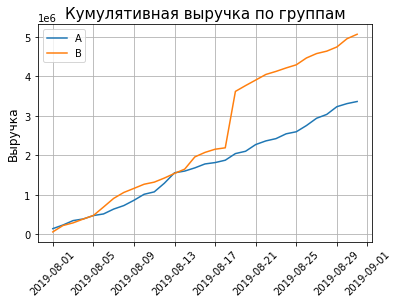

In [14]:
orders_filtered['date'] = pd.to_datetime(orders_filtered['date'], format = '%Y/%m/%d')
visitors['date'] = pd.to_datetime(visitors['date'], format = '%Y/%m/%d')

dates_groups = orders_filtered[['date', 'group']].drop_duplicates()

orders_agg = dates_groups.apply(lambda x: orders_filtered[np.logical_and(orders_filtered['date'] <= x['date'], orders_filtered['group'] == x['group'])]\
                                   .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])

visitors_agg = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date', 'group'])

cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_rev_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]
cumulative_rev_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

plt.plot(cumulative_rev_a['date'], cumulative_rev_a['revenue'], label='A')
plt.plot(cumulative_rev_b['date'], cumulative_rev_b['revenue'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по группам', fontsize=15)
plt.ylabel('Выручка', fontsize=12)
plt.grid()
plt.show()

Вначале выручки групп А и В были очень близки по значениям, c шестого дня выручка группы В начала показывать больший рост. 19 августа видим резкий рост выручки группы В, вероятно влияние аномально больших заказов. График выручки группы А показывает стабильный рост с небольшими колебаниями, что говорит о том, что каких то "всплесков" продаж не наблюдалось. 

### Кумулятивный средний чек по группам

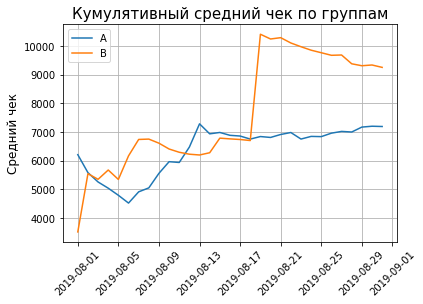

In [15]:
plt.plot(cumulative_rev_a['date'], cumulative_rev_a['revenue'] / cumulative_rev_a['orders'], label='A')
plt.plot(cumulative_rev_b['date'], cumulative_rev_b['revenue'] / cumulative_rev_b['orders'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title('Кумулятивный средний чек по группам', fontsize=15)
plt.ylabel('Средний чек', fontsize=12)
plt.grid()
plt.show()

Также как и с выручкой видим резкий рост 19 августа на 50% среднего чека группы В. До этого дня показатели, в основном, были лучше у группы В, но к 14 августа они примерно выравнились.

### Изменение кумулятивного среднего чека группы B по отношению к группе A

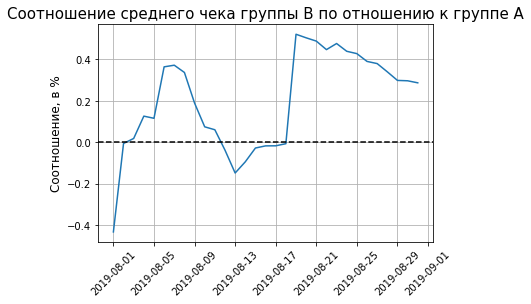

In [16]:
merged_cumulative_rev = cumulative_rev_a.merge(cumulative_rev_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_cumulative_rev['date'], (merged_cumulative_rev['revenueB'] / merged_cumulative_rev['ordersB']) / (merged_cumulative_rev['revenueA'] / merged_cumulative_rev['ordersA']) - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.title('Соотношение среднего чека группы B по отношению к группе A',fontsize=15)
plt.ylabel('Cоотношение, в %', fontsize=12)
plt.grid()
plt.show()

Видим очень резкие колебания. Необходимо посмотреть на наличие аномальных значений, которые могут повлиять на общую картину.

### Кумулятивная конверсия по группам

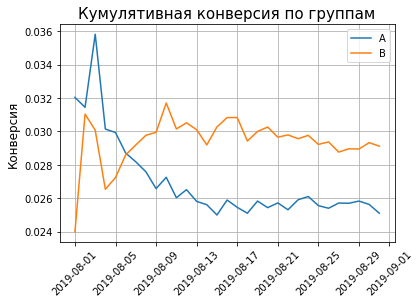

In [17]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.xticks(rotation=45)
#plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), 0.02, 0.038])
plt.title('Кумулятивная конверсия по группам', fontsize=15)
plt.ylabel('Конверсия', fontsize=12)
plt.grid()
plt.show()

После первых пяти дней кумулятивная конверсия группы В стабильно выше конверсии группы А.

### Изменение кумулятивной конверсии группы B по отношению к группе A

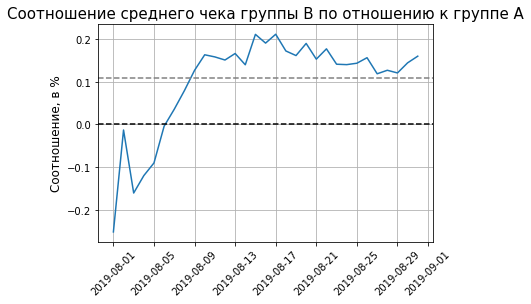

In [18]:
merged_cumulative_conversion = cumulative_data_a[['date', 'conversion']].merge(cumulative_data_b[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(merged_cumulative_conversion['date'], merged_cumulative_conversion['conversionB'] / merged_cumulative_conversion['conversionA'] - 1, label='Относительный прирост конверсии группы B относительно группы A') 
plt.xticks(rotation=45)
#plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), -0.2, 0.25])
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.11, color='grey', linestyle='--')
plt.title('Соотношение среднего чека группы B по отношению к группе A',fontsize=15)
plt.ylabel('Cоотношение, в %', fontsize=12)
plt.grid()           
plt.show()

Результаты группы B после 8 августа лучше группы A более чем на 11%.

### Количество заказов по пользователям

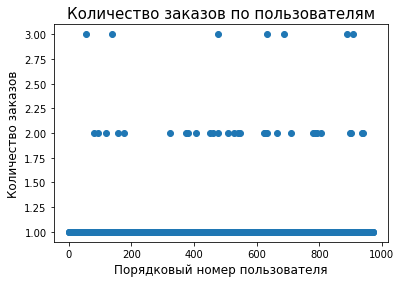

In [19]:
orders_by_users = orders_filtered.groupby('visitor_id', as_index=False).agg({'transaction_id' : 'nunique'})

x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['transaction_id'])
plt.title('Количество заказов по пользователям', fontsize=15)
plt.xlabel('Порядковый номер пользователя', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.show()

Основная масса пользователей совершают 1 заказ. Но есть пользователи с 2 и 3 заказами.

### Определяем границу для выявления аномальных пользователей по количеству заказов

In [20]:
np.percentile(orders_by_users['transaction_id'], [95, 99])

array([1., 2.])

95% пользователей совершают 1 заказ, 1% - совершает более 2 и более заказов.

### Стоимость заказов по пользователям

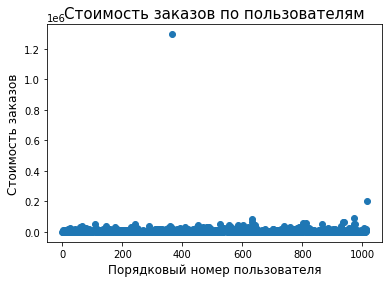

In [21]:
x_values = pd.Series(range(0, len(orders_filtered['revenue'])))
plt.scatter(x_values, orders_filtered['revenue'])
plt.title('Стоимость заказов по пользователям', fontsize=15)
plt.xlabel('Порядковый номер пользователя', fontsize=12)
plt.ylabel('Стоимость заказов', fontsize=12)
plt.show()

Видим заказ стоимостью свыше 1.2 млн, который и вызвал резкое колебание выручки и среднего чека. 

### Определяем границу для выявления аномальных пользователей по стоимости заказа

In [22]:
np.percentile(orders_filtered['revenue'], [95, 99])

array([26785., 53904.])

95% пользователей совершают заказы стоимостью до 26785, у 1% - стоимость заказов более почти 54000. Тем значительнее выглядит самый крупный заказ на 1.2 млн. 

###  Cтатистическая значимость различий в конверсии между группами по «сырым» данным

Подготовим данные. Делаем общую таблицу с кумулятивными данными по выручке, заказам, посещениям по каждой группе и по каждому дню.

In [23]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cumulative_a = visitors_daily_a.apply(lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg({'date': 'max', 'visitors_per_date_a': 'sum'}), axis=1)
visitors_cumulative_a.columns = ['date', 'visitors_cumulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cumulative_b = visitors_daily_b.apply(lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg({'date': 'max', 'visitors_per_date_b': 'sum'}), axis=1)
visitors_cumulative_b.columns = ['date', 'visitors_cumulative_b']

orders_daily_a = orders_filtered[orders_filtered['group'] == 'A'].groupby('date', as_index=False).agg({'transaction_id': 'nunique', 'revenue': 'sum'})
orders_daily_a.columns = ['date', 'orders_per_date_a', 'rev_per_date_a']

orders_cumulative_a = orders_daily_a.apply(lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg({'date': 'max', 'orders_per_date_a': 'sum', 'rev_per_date_a': 'sum'}), axis=1)
orders_cumulative_a.columns = ['date', 'orders_cumulative_a', 'rev_cumulative_a']

orders_daily_b = orders_filtered[orders_filtered['group'] == 'B'].groupby('date', as_index=False).agg({'transaction_id': 'nunique', 'revenue': 'sum'})
orders_daily_b.columns = ['date', 'orders_per_date_b', 'rev_per_date_b']

orders_cumulative_b = orders_daily_b.apply(lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg({'date': 'max', 'orders_per_date_b': 'sum', 'rev_per_date_b': 'sum'}), axis=1)
orders_cumulative_b.columns = ['date', 'orders_cumulative_b', 'rev_cumulative_b']

df = (orders_daily_a.merge(orders_daily_b, left_on='date', right_on='date', how='left')
.merge(orders_cumulative_a, left_on='date', right_on='date', how='left')
.merge(orders_cumulative_b, left_on='date', right_on='date', how='left')
.merge(visitors_daily_a, left_on='date', right_on='date', how='left')
.merge(visitors_daily_b, left_on='date', right_on='date', how='left')
.merge(visitors_cumulative_a, left_on='date', right_on='date', how='left')
.merge(visitors_cumulative_b, left_on='date', right_on='date', how='left'))
df.head()


,date,orders_per_date_a,rev_per_date_a,orders_per_date_b,rev_per_date_b,orders_cumulative_a,rev_cumulative_a,orders_cumulative_b,rev_cumulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cumulative_a,visitors_cumulative_b
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,718.0,709.0,718.0,709.0
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,618.0,580.0,1336.0,1289.0
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507.0,507.0,1843.0,1796.0
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,712.0,767.0,2555.0,2563.0
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,753.0,705.0,3308.0,3268.0


Сформулируем гипотезы.

Н0: различий в конверсии между группами нет. 

Н1: различия в конверсии между группами есть.

В данном случае выбираем stats.mannwhitneyu, так как в данных есть выбросы, которые существенно влияют на общую картину.

In [24]:
orders_by_users_a = orders_filtered[orders_filtered['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = orders_filtered[orders_filtered['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'})
orders_by_users_b.columns = ['visitor_id', 'orders']

sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(df['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)
sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(df['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

alpha = .05
results = stats.mannwhitneyu(sample_a, sample_b)[1]
print('p-значение: {0:.5f}'.format(results))

if results < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Относительный прирост конверсии группы В к группе А: {0:.3f}'.format((sample_b.mean() / sample_a.mean() - 1) * 100))    

p-значение: 0.01096
Отвергаем нулевую гипотезу
Относительный прирост конверсии группы В к группе А: 15.993


В конверсии между группами есть статистически значимые различия, нулевую гипотезу отвергаем.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза: различий в среднем чеке между группами нет. 

Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [25]:
results = stats.mannwhitneyu(orders_filtered[orders_filtered['group'] == 'A']['revenue'], orders_filtered[orders_filtered['group'] == 'B']['revenue'])[1]
print('p-значение: {0:.5f}'.format(results))

if results < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Относительный прирост среднего чека группы В к группе А: {0:.3f}'.format((orders_filtered[orders_filtered['group'] == 'B']['revenue'].mean() / orders_filtered[orders_filtered['group'] == 'A']['revenue'].mean() - 1) * 100))    

p-значение: 0.82949
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы В к группе А: 28.660


Статистически значимых отличий среднего чека между группами нет. При этом прирост среднего чека составил почти 29%.

### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

"Очищаем" данные от аномалий.

Основываясь на процентном соотношении количества пользователей по количеству заказов и по стоимости заказа, установим границу заказов в 2 и более, а стоимость заказов 27000. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% заказов с наибольшей стоимостью. 

In [26]:
users_many_orders = pd.concat([orders_by_users_a[orders_by_users_a['orders'] > 1]['visitor_id'], orders_by_users_b[orders_by_users_b['orders'] > 1]['visitor_id']], axis=0)

users_expensive_orders = orders_filtered[orders_filtered['revenue'] >= 27000]['visitor_id']

abnormal_users = pd.concat([users_many_orders, users_expensive_orders], axis=0).drop_duplicates()

Сформулируем гипотезы.

Нулевая: различий в конверсии между группами нет.

Альтернативная: различия в конверсии между группами есть.

In [27]:
sample_a_filtered = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))]['orders'], pd.Series(0, index=np.arange(df['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)

sample_b_filtered = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))]['orders'], pd.Series(0, index=np.arange(df['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0)

results = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]
print('p-значение: {0:.5f}'.format(results))

if results < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Относительный прирост конверсии группы В к группе А: {0:.3f}'.format((sample_b_filtered.mean() / sample_a_filtered.mean() - 1) * 100))    

p-значение: 0.01585
Отвергаем нулевую гипотезу
Относительный прирост конверсии группы В к группе А: 17.407


Результат повторил итоги расчёта по "сырым" данным.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Нулевая гипотеза: различий в среднем чеке между группами нет.

Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [28]:
results = stats.mannwhitneyu(orders_filtered[np.logical_and(orders_filtered['group'] == 'A', np.logical_not(orders_filtered['visitor_id'].isin(abnormal_users)))]['revenue'], orders_filtered[np.logical_and(orders_filtered['group'] == 'B', np.logical_not(orders_filtered['visitor_id'].isin(abnormal_users)))]['revenue'])[1]
print('p-значение: {0:.5f}'.format(results))

if results < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Относительный прирост среднего чека группы В к группе А: {0:.3f}'.format((orders_filtered[np.logical_and(orders_filtered['group'] == 'B', np.logical_not(orders_filtered['visitor_id'].isin(abnormal_users)))]['revenue'].mean() / orders_filtered[np.logical_and(orders_filtered['group'] == 'A', np.logical_not(orders_filtered['visitor_id'].isin(abnormal_users)))]['revenue'].mean() - 1) * 100))     

p-значение: 0.72713
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы В к группе А: -3.373


Подтвердилась гипотеза о равенстве средних чеков, при этом в "очищенных" данных средний чек группы В ниже.

### Вывод по результатам теста

- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- По "сырым" данным нет статистически значимого различия по среднему чеку между группами. После удаления аномалий средний чек группы В оказался ниже.
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A более чем на 11%.
- По графику различия среднего чека сложно сделать какие-либо определённые выводы, кроме выдвижения предположения о наличии аномалий.
- Таким образом можно остановить тест и зафиксировать победу группы В.